<a href="https://colab.research.google.com/github/miknad2319/CS82-Milestone-3/blob/main/Milestone3_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will leverage a pretrained Roberta model from HF transformers using PyTorch Datasets, Pytorch Lighting Data Modules and Neural Net Modules.

### 1. We install the necessary dependencies

In [2]:
# Colab doesn't have transformers or py-torch lightning pre-installed
# the %%capture command stifles pip install output messages
%%capture
!pip install transformers
!pip install pytorch-lightning

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc #true positivity rate (area under the curve)
import torch.nn.functional as F

In [5]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [6]:
train_path = '/content/drive/MyDrive/Spring 2023/Data Mining/Milestone3/train.csv'
test_path = '/content/drive/MyDrive/Spring 2023/Data Mining/Milestone3/test.csv'
test_labels_path = '/content/drive/MyDrive/Spring 2023/Data Mining/Milestone3/test_labels.csv'


### 2. We create a new file with test comments and their labels concatenated into one Dataset

In [7]:
# read in test files and the test label files as DataFrames
test_df = pd.read_csv(test_path)
test_labels_df = pd.read_csv(test_labels_path)

In [8]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
test_labels_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [10]:
### perform the concatenations between test and labels DataFrames
test_df = pd.concat([test_df.iloc[:, 1], test_labels_df.iloc[:, 1:]], axis = 1)

In [11]:
# confirming that our concatenation worked
test_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [12]:
# write this new df to csv so we can call it later
test_df.to_csv("test-dataset.csv")

In [13]:
# set this new test dataset path for later
test_dataset_path = "/content/drive/MyDrive/Spring 2023/Data Mining/Milestone3/test-dataset.csv"

In [14]:
proof_this_worked = pd.read_csv(test_dataset_path)

In [ ]:
proof_this_worked.head()

,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,1,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,3,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,4,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


### 3. Read in training data as a DataFrame

In [15]:
train_data = pd.read_csv(train_path)

In [16]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
# checking for data types 
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [18]:
train_data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

### 4. Pre-Processing

#### We can see that there are 6 possible classes, or attributes, for each comment. Let's add another class called "healthy" that has value of 1 when the 6 others are 0.

In [19]:
#Lets define a method that checks the values of each column and returns 1 or 0.

def healthy_filter(df):
  if (df["toxic"]==0) and (df["severe_toxic"]==0) and (df["obscene"]==0) and (df["threat"]==0) and (df["insult"]==0) and (df["identity_hate"]==0):
    return 1
  else:
    return 0

In [20]:
# We apply the above method to the train_data DataFrame 
train_data["healthy"] = train_data.apply(healthy_filter,axis=1)

In [34]:
# We don't really need to do this but oh well
train_data["unhealthy"] = np.where(train_data["healthy"] == 1, 0, 1)

In [35]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,healthy,unhealthy
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,0


In [22]:
train_data["healthy"].value_counts()

1    143346
0     16225
Name: healthy, dtype: int64

#### We can see that the number of "healthy" comments far outweighs the number of toxic comments

In [36]:
attributes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'healthy']

<Axes: >

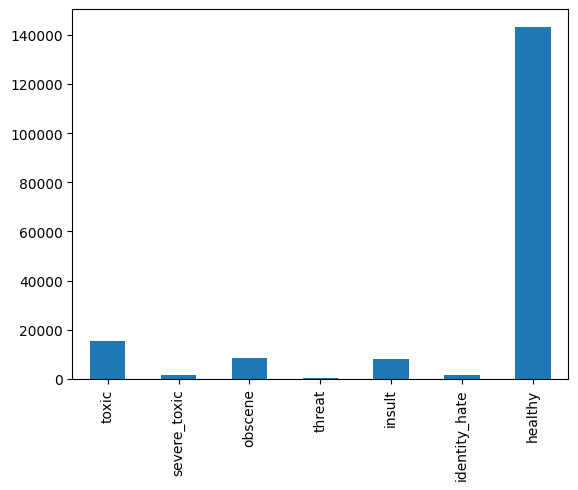

In [37]:
train_data[attributes].sum().plot.bar()

In [38]:
train_data.comment_text.str.len().max()#max comment length

5000

In [39]:
train_data.comment_text.str.len().min()#min comment length

6

In [40]:
train_data.comment_text.str.len().mean()# avg comment length

394.0732213246768

In [41]:
healthy_train = train_data.loc[train_data["healthy"] == 1]

In [28]:
healthy_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,healthy
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [43]:
# We now know how to preprocess the data and seperate each case (healthy vs toxic). Let's apply this knowledge to prep our data to train our model.

### 5. Dataset

Using our findings from above, we will create a PyTorch dataset that takes the same number samples from the "toxic" subset and the "healthy" subsets.

In [ ]:
# Since we're going to use the HF Roberta model, we'll pass the raw comment text through the Roberta Base tokenizer, defined in the next cell
# All torch dataset subclasses require an init, len, and get item method

class Comments_Dataset(Dataset):
  def __init__(self, data_path, tokenizer, attributes, max_token_len = 128, sample=5000):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()

  ### Uses the above pre-processing steps
  def _prepare_data(self):
    data = pd.read_csv(self.data_path)
    data["healthy"] = data.apply(healthy_filter,axis=1)
    data["unhealthy"] = np.where(data['healthy']==1, 0, 1)
    if self.sample is not None:
      unhealthy = data.loc[data["healthy"] == 0]
      healthy = data.loc[data["healthy"] == 1]
      self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state=42)])# this is where we take the sample of healthy comments
    else:
      self.data = data

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,index):
    item = self.data.iloc[index]
    comment = str(item.comment_text)
    attributes = torch.FloatTensor(item[self.attributes])# this is where we turn the attributes into labels
    tokens = self.tokenizer.encode_plus(comment,
                                      add_special_tokens=True,
                                      return_tensors='pt',
                                      truncation=True,
                                      padding='max_length',
                                      max_length=self.max_token_len,
                                      return_attention_mask = True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}#flattened to make it compatible
    #with lighting module

In [ ]:
# intializing the train and validation datasets
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

comments_ds = Comments_Dataset(train_path, tokenizer, attributes=attributes)#default sample of 5000
comments_ds_val = Comments_Dataset(test_dataset_path, tokenizer, attributes, sample=None)

In [ ]:
# checking first item in the random batch: the 1s mean blank, which means that this was a short comment
comments_ds.__getitem__(0)

{'input_ids': tensor([    0,   347, 13181,   104, 23806,  2076, 32882, 10540,   221, 17588,
          5495, 18103,  5121, 20060, 32008,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [ ]:
len(comments_ds)

21225

### 6. Data Module

In [ ]:
# Data Module is a py-lightning wrapper for torch dataloaders intended for fast integration with pl lightning neural network modules

class Comments_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path, attributes, batch_size: int = 16, max_token_length: int = 128,  model_name='roberta-base'):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = Comments_Dataset(self.train_path, attributes=self.attributes, tokenizer=self.tokenizer)
      self.val_dataset = Comments_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)
    if stage == 'predict':
      self.val_dataset = Comments_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)


In [ ]:
# We create the comments data module that contains all the data we're going to use and the preprocessing we've developed
comments_data_module = Comments_Data_Module(train_path, test_dataset_path, attributes=attributes)

In [ ]:
comments_data_module.setup()#initialize to the default "fit" method (see line 16 in the first cell of this section)

In [ ]:
comments_data_module.train_dataloader()

In [ ]:
len(comments_data_module.train_dataloader())

1327

### 7. MODEL

We are performing transfer learning, as we leverage a pretrained Roberta base model by running a fit through our data using our labels, and then by extracting the last hidden layer of the pretrained model and running it through our own fully connected linear layer that outputs 7 logits (1 for each toxicity class and 1 for healthy comments)

In [ ]:
# We will initialize our comment classifier as an instance of a neural network, using a config dictionary where we will name
# the necessary parameters and their values.

class Comment_Classifier(pl.LightningModule):
#the config dict has the huggingface parameters in it
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)#initializing our classifier weight to reflect the normal distribution
    self.loss_func = nn.CrossEntropyLoss()# multi class classification requires cross entropy loss
    self.dropout = nn.Dropout()
    
  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits / classification layers
    # we run dropout to lessen overfitting on the training set
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)# nonlinear activation function
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
      # the .view method as shown asks the computer to determine the best row-axis dimension size, whille the column-axis dimension size is 
      # equal to the number of classes.

  #### the following methods will be used with the torch lightning data modules, which pass batches of training data to the model

  def training_step(self, batch, batch_index):# we don't use these, although these are passed
    loss, outputs = self(**batch)
    self.log("train loss ", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):#no loss or logs taken
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    # adam is a fancy stochastic descent that increases the lr sharply at the beginning and tapers out as the epochs go on
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])# the config dictionary coming into play here

    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)
    

In [ ]:
### our config dictionary
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2, 
    'train_size': len(comments_data_module.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 10
}

#initializing our model with the config dictionary
model = Comment_Classifier(config)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# testing model input and output is working

idx=0
input_ids = comments_ds.__getitem__(idx)['input_ids']
attention_mask = comments_ds.__getitem__(idx)['attention_mask']
labels = comments_ds.__getitem__(idx)['labels']
model.cpu()
loss, output = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))
print(labels.shape, output.shape, output)#outputs being our final logits.

#### Keep in mind we have not trained our model yet!!

torch.Size([7]) torch.Size([1, 7]) tensor([[ 1.0395,  0.9591, -0.3557,  0.3359, -1.0812, -0.0684,  0.4863]],
       grad_fn=<AddmmBackward0>)


In [ ]:
# reinitializing the comments data module for freshness's sake
comments_data_module = Comments_Data_Module(train_path, test_dataset_path, attributes=attributes, batch_size=config['batch_size'])
comments_data_module.setup()

# reinitializing our model
model = Comment_Classifier(config)

#train
trainer = pl.Trainer(max_epochs=config['n_epochs'], accelerator='gpu', num_sanity_val_steps=50)# pl automatically detects your gpu unit(cuda, mps, etc.)
trainer.fit(model, comments_data_module)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
model_save_path = "/content/drive/MyDrive/Spring 2023/Data Mining/Milestone3/model_state_dict.pt"

In [ ]:
#or 
torch.save(model.cpu().state_dict(),model_save_path)

### We have finetuned our classifier based on Roberta on our dataset. We save the model state dictionary, as is recommended by the torch docs. We will use this finetuned model state dict to initialize our comments classifier on our local machine, through which we are deploying the streamlit app.

https://pytorch.org/tutorials/beginner/saving_loading_models.html